In [1]:
# arrays
import numpy as np

# unpacking files
import tarfile

# fits
from astropy.io import fits
from astropy.utils.data import download_file

# plotting
import matplotlib.pyplot as plt
from matplotlib import ticker

# stella CNN functions
import stella

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D

# sklearn for performance metrics
from sklearn import metrics

# lightkurve
from lightkurve.search import search_lightcurve

# from IPython import get_ipython
# get_ipython().run_line_magic('matplotlib', 'notebook')

# set random seed for reproducibility 
np.random.seed(42)

2023-05-01 03:38:54.531342: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 03:38:54.579551: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-01 03:38:54.580342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-01 03:38:59.027322: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
imports

NameError: name 'imports' is not defined

In [3]:
# will need detailed installation instructions...or have TIKE provide stella!

In [4]:
# build train, test, validation dataset, "ds"
data_dir = './hellouniverse_stella_500/'

In [5]:
file_url = 'https://archive.stsci.edu/hlsps/hellouniverse/hellouniverse_stella_500.tar.gz'

# open file
file = tarfile.open(download_file(file_url, cache=True))
  
# extracting file
file.extractall('.')
file.close()

In [6]:


ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 428.82it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [47]:
len(download.flare_table)

4000

In [13]:
ls

002760232_sector02.npy  141769356_sector01.npy
002761472_sector02.npy  141769356_sector02.npy
005640393_sector02.npy  141771691_sector01.npy
005656273_sector02.npy  141771691_sector02.npy
005676537_sector02.npy  141807839_sector02.npy
005725904_sector02.npy  141914082_sector01.npy
005727213_sector02.npy  141945750_sector01.npy
005796048_sector02.npy  141975926_sector01.npy
005796211_sector02.npy  141975926_sector02.npy
007151484_sector02.npy  142052608_sector01.npy
008962122_sector02.npy  142052608_sector02.npy
008991030_sector02.npy  142052876_sector01.npy
009003103_sector02.npy  142052876_sector02.npy
009072094_sector02.npy  142082467_sector01.npy
009102812_sector02.npy  142082467_sector02.npy
009210746_sector02.npy  142082942_sector01.npy
009664841_sector02.npy  142082942_sector02.npy
009708387_sector02.npy  142085618_sector02.npy
012359032_sector02.npy  142086812_sector01.npy
012359079_sector02.npy  142086812_sector02.npy
012377787_sector02.npy  142087340_sector01.npy
012393800_sec

In [9]:
# take 2: more data
download = stella.DownloadSets(fn_dir='.')
download.download_catalog()
download.flare_table = download.flare_table[0:4000]
download.download_lightcurves()

  2%|▏         | 13/587 [00:28<20:48,  2.17s/it]


KeyboardInterrupt: 

In [ ]:
ds = stella.FlareDataSet(downloadSet=download)

In [14]:
# hm, check the URL.
ds = stella.FlareDataSet(fn_dir='.',
                         catalog='./'+'Guenther_2020_flare_catalog.txt')

Reading in training set files.


100%|██████████| 759/759 [00:01<00:00, 497.87it/s]


4056 positive classes (flare)
16938 negative classes (no flare)
24.0% class imbalance



In [7]:
# thought: stella does pre-conditioning. so we need to replicate that if we want to apply elsewhere.
# nope! no worries. it a;ready dies that if we do the dataset thing.

In [8]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]

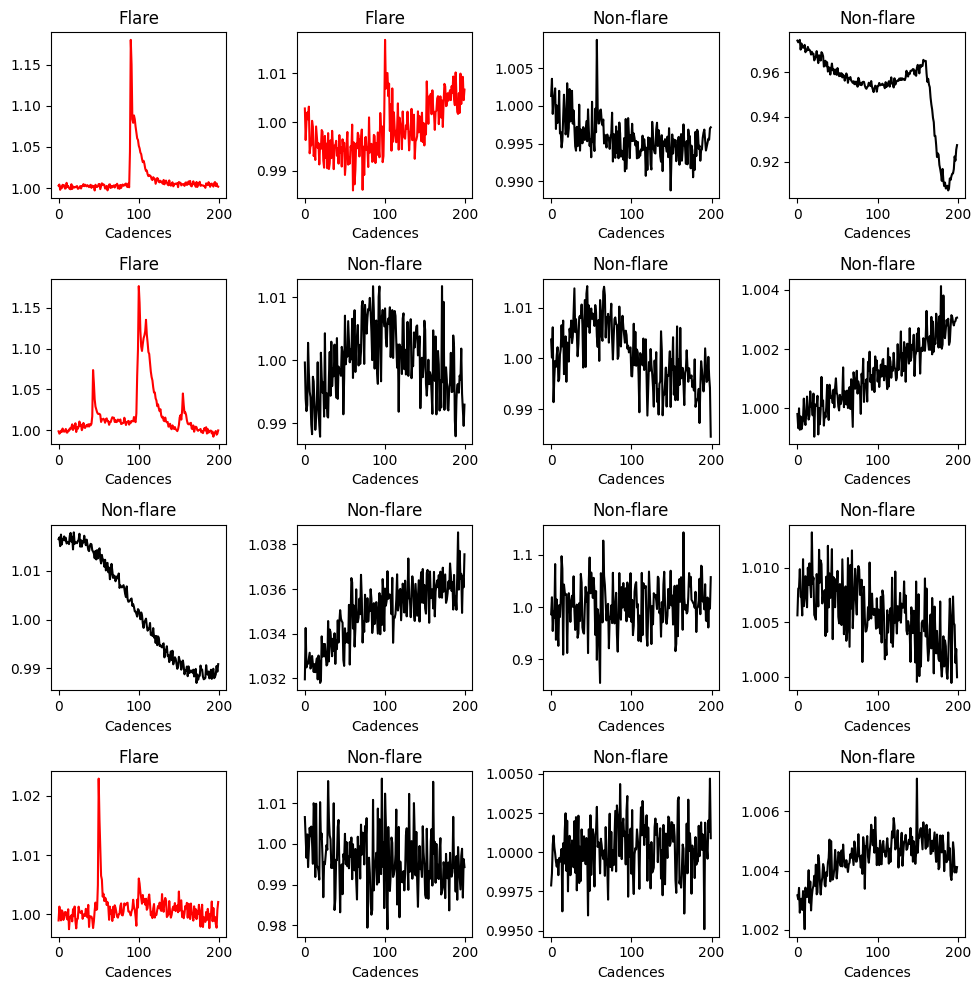

In [9]:
# select random image indices:
example_ids = np.random.choice(len(ds.train_labels), 16)

# pull the lightcurves and labels for these selections
example_lightcurves = [ds.train_data[j] for j in example_ids]
example_labels = [ds.train_labels[j] for j in example_ids]


# initialize your figure
fig = plt.figure(figsize=(10, 10))

# loop through the randomly selected images and plot with labels
colors = {1: 'r', 0: 'k'}
titles = {1: 'Flare', 0: 'Non-flare'}
for i in range(len(example_ids)):
    plt.subplot(4, 4, i + 1)
    plt.plot(example_lightcurves[i], color=colors[example_labels[i]])
    plt.title(titles[example_labels[i]])
    plt.xlabel('Cadences')
    
plt.tight_layout()
plt.show()

In [10]:
# ------------------------------------------------------------------------------
# generate the model architecture
# Written for Keras 2
# ------------------------------------------------------------------------------

seed = 2
np.random.seed(seed)

filter1 = 16
filter2 = 64
dense = 128 # was 32
dropout = 0.1

# Define architecture for model
data_shape = np.shape(ds.train_data)
input_shape = (np.shape(ds.train_data)[1], 1)

x_in = Input(shape=input_shape)
c0 = Convolution1D(7, filter1, activation='relu', padding='same', input_shape=input_shape)(x_in)
b0 = MaxPooling1D(pool_size=2)(c0)
d0 = Dropout(dropout)(b0)

c1 = Convolution1D(3, filter2, activation='relu', padding='same')(d0)
b1 = MaxPooling1D(pool_size=2)(c1)
d1 = Dropout(dropout)(b1)


f = Flatten()(d1)
z0 = Dense(dense, activation='relu')(f)
d2 = Dropout(dropout)(z0)
y_out = Dense(1, activation='sigmoid')(d2)

cnn = Model(inputs=x_in, outputs=y_out)

In [11]:
# something to consider: hyperparameter optimization.
# something to consider: different sections.

In [12]:
# Compile Model
optimizer = 'adam'
fit_metrics = ['accuracy'] 
loss = 'binary_crossentropy'
cnn.compile(loss=loss, optimizer=optimizer, metrics=fit_metrics)
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 1)]          0         
                                                                 
 conv1d (Conv1D)             (None, 200, 7)            119       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 7)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 7)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 3)            1347      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 3)            0         
 1D)                                                         

In [13]:
nb_epoch = 100
batch_size = 64
shuffle = True

# Train
history = cnn.fit(ds.train_data, ds.train_labels,
                  batch_size=batch_size, 
                  epochs=nb_epoch, 
                  validation_data=(ds.val_data, ds.val_labels), 
                  shuffle=shuffle,
                  verbose=True)

Epoch 1/100
23/23 [==============================] - 2s 28ms/step - loss: 0.5990 - accuracy: 0.7254 - val_loss: 0.6066 - val_accuracy: 0.7088
Epoch 2/100
23/23 [==============================] - 0s 18ms/step - loss: 0.5906 - accuracy: 0.7309 - val_loss: 0.6022 - val_accuracy: 0.7088
Epoch 3/100
23/23 [==============================] - 0s 22ms/step - loss: 0.5757 - accuracy: 0.7309 - val_loss: 0.6002 - val_accuracy: 0.7088
Epoch 4/100
23/23 [==============================] - 0s 18ms/step - loss: 0.5809 - accuracy: 0.7336 - val_loss: 0.5983 - val_accuracy: 0.7088
Epoch 5/100
23/23 [==============================] - 0s 17ms/step - loss: 0.5675 - accuracy: 0.7370 - val_loss: 0.5881 - val_accuracy: 0.7143
Epoch 6/100
23/23 [==============================] - 0s 18ms/step - loss: 0.5709 - accuracy: 0.7439 - val_loss: 0.5859 - val_accuracy: 0.7143
Epoch 7/100
23/23 [==============================] - 0s 17ms/step - loss: 0.5636 - accuracy: 0.7500 - val_loss: 0.5870 - val_accuracy: 0.7143
Epoch 

In [22]:
# save the model to file
cnn_file = 'initial_flare_model_small_dataset.h5'
cnn.save(cnn_file)
# this would be a great spot for payising and doing hyperparameter optimization. Either leaving it as exercise or exploring.

In [8]:
# save the model to file
cnn_file = 'initial_flare_model.h5'
# cnn.save(cnn_file)
cnn = stella.ConvNN('.').load_model(cnn_file)
# todo: figure out how to load the model :)
# this would be a great spot for payising and doing hyperparameter optimization. Either leaving it as exercise or exploring.

Can only use stella.ConvNN.predict().


AttributeError: 'NoneType' object has no attribute 'val_data'

In [23]:
# what does this also do? it has a lot

In [24]:
# put in: what's a confusion matrix?
# put in: how to *see* if things are overfitting

In [15]:
def plot_confusion_matrix(cnn, input_data, input_labels):
    
    # Compute flare predictions for the test dataset
    predictions = cnn.predict(input_data)

    # Convert to binary classification 
    predictions = (predictions > 0.5).astype('int32') 
    
    # Compute the confusion matrix by comparing the test labels (ds.test_labels) with the test predictions
    cm = metrics.confusion_matrix(input_labels, predictions, labels=[0, 1])
    cm = cm.astype('float')

    # Normalize the confusion matrix results. 
    cm_norm = cm / cm.sum(axis=1)[:, np.newaxis]
    
    # Plotting
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.matshow(cm_norm, cmap='binary_r')

    plt.title('Confusion matrix', y=1.08)
    
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Flare', 'No Flare'])
    
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Flare', 'No Flare'])

    plt.xlabel('Predicted')
    plt.ylabel('True')

    fmt = '.2f'
    thresh = cm_norm.max() / 2.
    for i in range(cm_norm.shape[0]):
        for j in range(cm_norm.shape[1]):
            ax.text(j, i, format(cm_norm[i, j], fmt), 
                    ha="center", va="center",color="white" if cm_norm[i, j] < thresh else "black")
    plt.show()

6/6 [==============================] - 0s 3ms/step


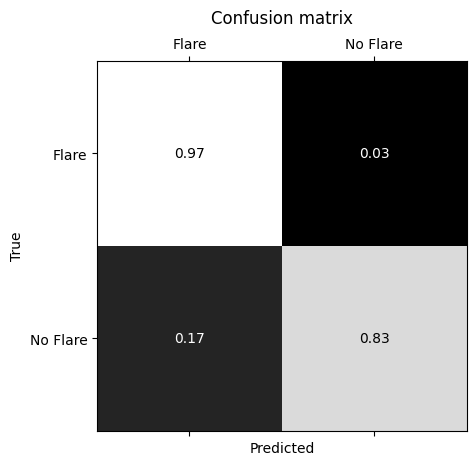

In [16]:
plot_confusion_matrix(cnn, ds.test_data, ds.test_labels)


In [88]:
# down to 31% no flare where flare at :1000. took 30 min to download. let's double again. 
# down to 23% no flare when flare at :2000. let's double again. but only 98% detected!
# down to 15% no flare when flare at :4000. let's double again. but only 99% detected!
# that's as goooood as it gets though.
# ican get to 8% with more nodes

In [ ]:
# going up to 563 already got us down to .77 from .8. so yeah...factor of 10 would help us.

In [ ]:
# we can't use this in the real world...the flase positive rate is way too high!

In [20]:
# how do we read this? top right is how many true flares are classified as true flares.
# bottom left is the tricky bit — we're likely to categorize something as a flare even if it isn't!

In [21]:
1

1

In [15]:
# augment: train on *all* of the existing training data.

In [16]:
# this is the stella pre-processing below.

In [42]:
# ticids = ['120461526', '278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['394015919']
# for all the selected targets, pull the available lightcurves using the lightkurve package
lcs = []
# should tqdm these
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=[1, 2], author='SPOC')
    lc = lc.download_all()
    lcs.append(lc)

In [43]:
for lc in lcs:
    if len(lc)>0: lc = lc[0] 
    if not np.all(np.isfinite(lc.flux)):
        print('bad!')

In [44]:
# load the CNN using `stella`
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

In [45]:
# huh. this all looks bad!

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


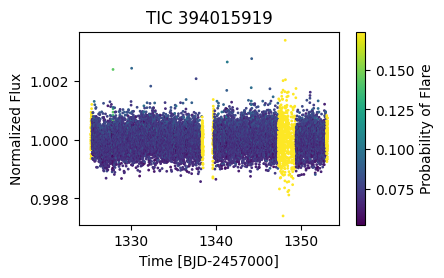

In [47]:
fig = plt.figure(0, [8, 10])

for i, lc in enumerate(lcs):
    # pull out on the first light curve in each set, if more than one exist
    if len(lc)>0: lc = lc[0]
        
    # predict the flare probability light cuvey for the input data using `stella` 
    # (which applies the necessary pre-processing to the data for input to the CNN)
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ax = fig.add_subplot(4,2,i+1)
    im = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
    
    plt.colorbar(im, ax=ax, label='Probability of Flare')
    ax.set_xlabel('Time [BJD-2457000]')
    ax.set_ylabel('Normalized Flux')
    ax.set_title('TIC {}'.format(lc.targetid));
plt.tight_layout()
plt.show()

# New section: fitting the flares!

In [24]:
cnn.predict(modelname=MODEL,
            times=lc.time,
            fluxes=lc.flux,
            errs=lc.flux_err)

NameError: name 'MODEL' is not defined

In [53]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])

In [54]:
ff.identify_flare_peaks(threshold=0.1)

ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]WARNING: TimeDeltaMissingUnitWarning: Numerical value without unit or explicit format passed to TimeDelta, assuming days [astropy.time.core]
/home/jovyan/userenv/lib/python3.8/site-packages/stella-0.2.0rc2-py3.8.egg/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]


IndexError: index 18277 is out of bounds for axis 0 with size 18277

ValueError: 'c' argument has 18277 elements, which is inconsistent with 'x' and 'y' with size 18279.

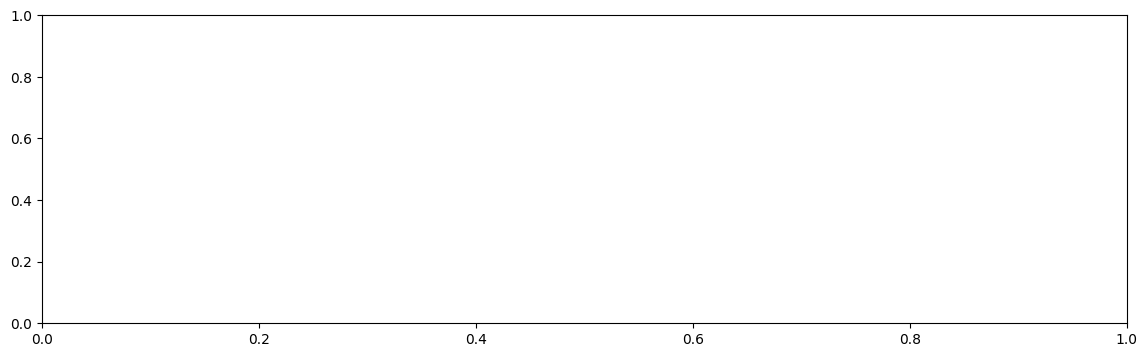

In [55]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn_stella.predictions[0], s=5)

for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)

plt.ylim(0.94,1.3)
plt.xlabel('Time [BJD - 2457000]')
plt.ylabel('Normalized Flux');

In [ ]:
plt.figure(figsize=(14,4))
plt.scatter(ff.time[0], ff.flux[0], c=cnn.predictions[0], s=5)
for tpeak in ff.flare_table['tpeak']:
    plt.vlines(tpeak, 0,2, color='k', alpha=0.5, linewidth=5, zorder=0)
plt.xlim(1660,1666)
plt.ylim(0.96,1.05)

In [ ]:
# and try to see some relationship between these properties.

# New section: compare to rotation periods!

In [58]:
mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux], [lc.flux_err])


In [60]:
lc.time.value

array([1325.29993273, 1325.30132162, 1325.30271051, ..., 1353.17738539,
       1353.17877424, 1353.18016309])

In [59]:
mProt.run_LS()


Finding most likely periods:   0%|          | 0/1 [00:00<?, ?it/s]


ValueError: array must not contain infs or NaNs

In [ ]:
mProt.LS_results


In [ ]:
lc.fold(mProt.LS_results['avg_period_days'].data[0]).plot()


# New section: apply to a bunch of different light curves!